In [124]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [86]:
#load data as Pandas Dataframes
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_data = train_df.values
test_data = test_df.values

In [87]:
len(train_data)

1460

D:\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


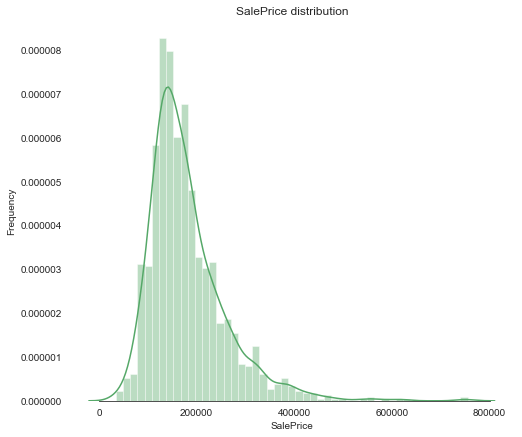

In [88]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
# Check the new distribution
sns.distplot(train_df['SalePrice'], color="g");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


In [89]:
# Skew and kurt
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())


Skewness: 1.882876
Kurtosis: 6.536282


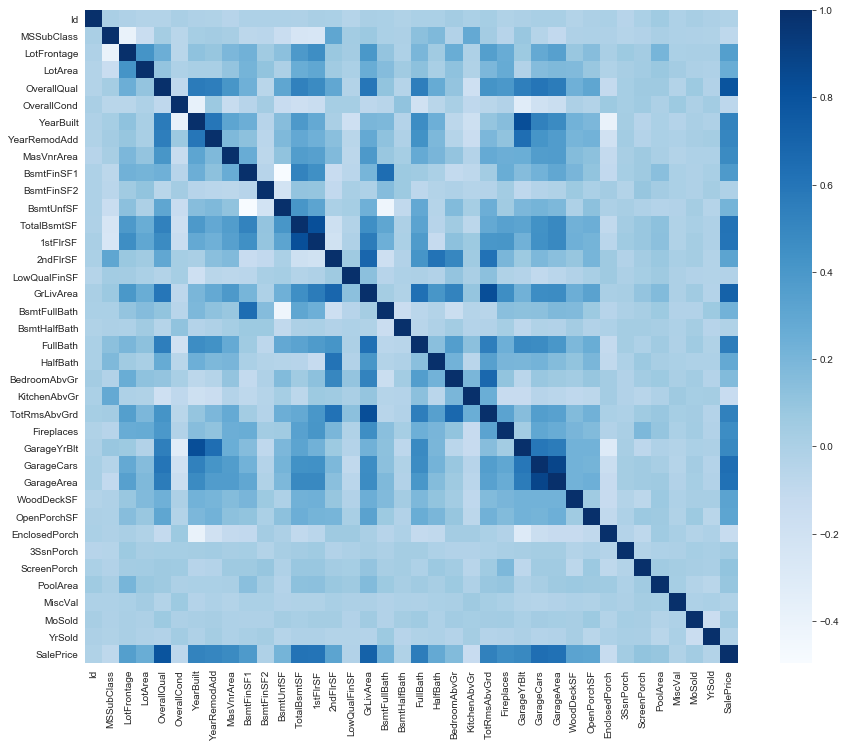

In [90]:
corr = train_df.corr()
plt.subplots(figsize = (15,12))
sns.heatmap(corr, cmap = "Blues", square = True )

In [91]:
# Use log(x) to fix skewness
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])


 mu = 12.02 and sigma = 0.40



D:\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


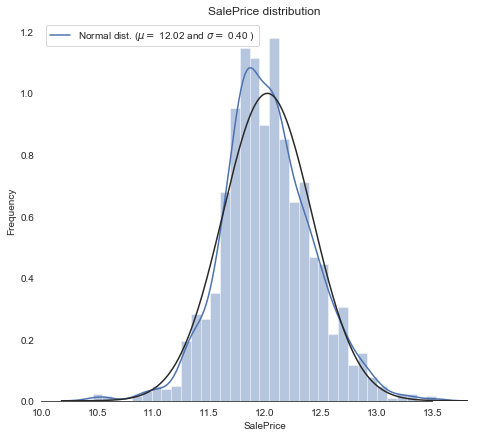

In [92]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#plot fixed distribution
sns.distplot(train_df['SalePrice'] , fit =stats.norm ,color="b");

# get fitted parameters
(mu, sigma) = stats.norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#plot distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [93]:
# Remove Outliers
train_df.drop(train_df[(train_df['OverallQual']<5) & (train_df['SalePrice']>200000)].index, inplace=True)
train_df.drop(train_df[(train_df['GrLivArea']>4500) & (train_df['SalePrice']<300000)].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [94]:
# Split features and labels
train_labels = train_df['SalePrice'].reset_index(drop=True)
train_features = train_df.drop(['SalePrice'], axis=1)
test_features = test_df

# combine dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape


(2917, 80)

In [95]:
# This function will get missing values in the datasets
def get_missing_value(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    percent = {}
    for i in range(0, len(df_cols)):
        percent.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    return percent
missing = get_missing_value(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

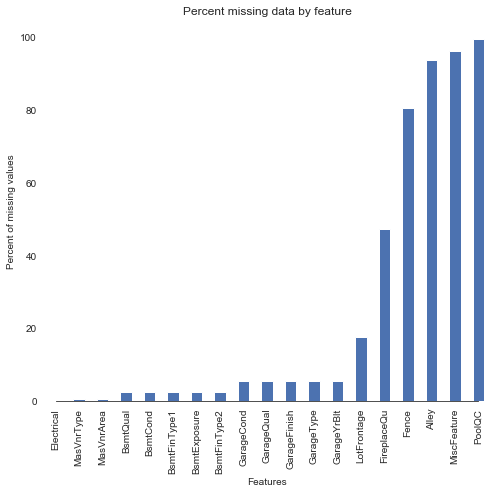

In [96]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train_df.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [97]:
# Convert some mis stored data types to strings
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)


In [98]:
def handle_missing(features):
    # data description shows NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace with simialr logic
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #data description showsNA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # replace to 0 because no garage means no cars
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # change to none due to data description
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # data description shows NA means None
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, fill the missing value with median in the neighborhood. 
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # rest of the data will be set to none since no specific decription given.
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [99]:
# check missing values again
missing = get_missing_value(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0)]

In [100]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

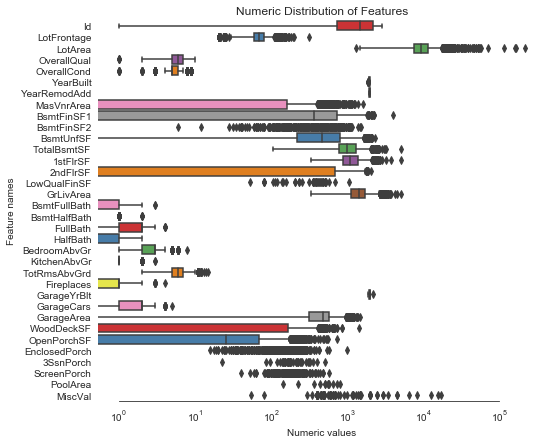

In [101]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [102]:
# Find skewness of top 10
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [103]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

D:\python\lib\site-packages\seaborn\categorical.py:446: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)


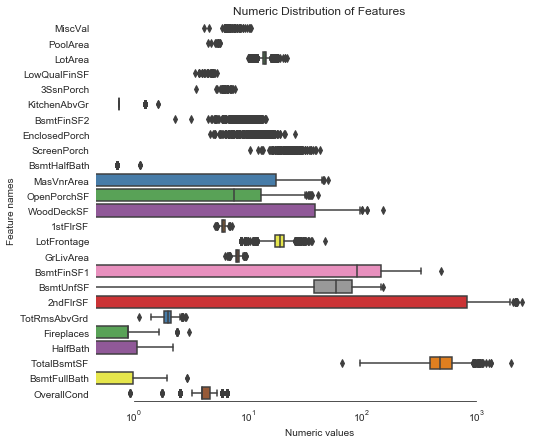

In [104]:
#check skewness
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [156]:
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 18 numerical features with Skew > 0.5 :


PoolArea         15.595057
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778336
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149133
2ndFlrSF          2.109410
dtype: float64

In [119]:
#Creating new features for the purpose of better estimation

In [105]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

In [117]:

for i in all_features['TotalBsmtSF']:
    if i<= 0:
        all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].np.exp(6)
    else:
         all_features['TotalBsmtSF'] = all_features['TotalBsmtSF']

for i in all_features['2ndFlrSF']:
     if i<= 0:
        all_features['2ndFlrSF'] = all_features['2ndFlrSF'].np.exp(6.5)
     else:
         all_features['2ndFlrSF'] = all_features['2ndFlrSF']
for i in all_features['GarageArea']:
    if i<= 0:
        all_features['GarageArea'] = all_features['GarageArea'].np.exp(6)
    else:
         all_features['GarageArea'] = all_features['GarageArea']
for i in all_features['LotFrontage']:
    if i<= 0:
        all_features['LotFrontage'] = all_features['LotFrontage'].np.exp(4.2)
    else:
         all_features['LotFrontage'] = all_features['LotFrontage']
for i in all_features['MasVnrArea']:
    if i<= 0:
        all_features['MasVnrArea'] = all_features['MasVnrArea'].np.exp(4)
    else:
         all_features['MasVnrArea'] = all_features['MasVnrArea']
for i in all_features['BsmtFinSF1']:
    if i<= 0:
        all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].np.exp(6.5)
    else:
         all_features['BsmtFinSF1'] = all_features['BsmtFinSF1']

In [118]:
for i in all_features['PoolArea']:
    if i > 0:
        all_features['haspool'] = 1
    else:
        all_features['haspool'] = 0
        
for i in all_features['2ndFlrSF']:
    if i > 0:
        all_features['has2ndfloor'] = 1
    else:
        all_features['has2ndfloor'] = 0
        
for i in all_features['GarageArea']:
    if i > 0:
        all_features['hasgarage'] = 1
    else:
        all_features['hasgarage'] = 0
for i in all_features['TotalBsmtSF']:
    if i > 0:
        all_features['hasbsmt'] = 1
    else:
        all_features['hasbsmt'] = 0
for i in all_features['Fireplaces']:
    if i > 0:
        all_features['hasfireplace'] = 1
    else:
        all_features['hasfireplace'] = 0
for i in all_features['GarageCars']:
    if i > 0:
        all_features['GarageCars'] = 1
    else:
        all_features['GarageCars'] = 0

In [30]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [31]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [33]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape
# Remove duplicates
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [ ]:
# check skewness
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [34]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 379), (1458,), (1459, 379))

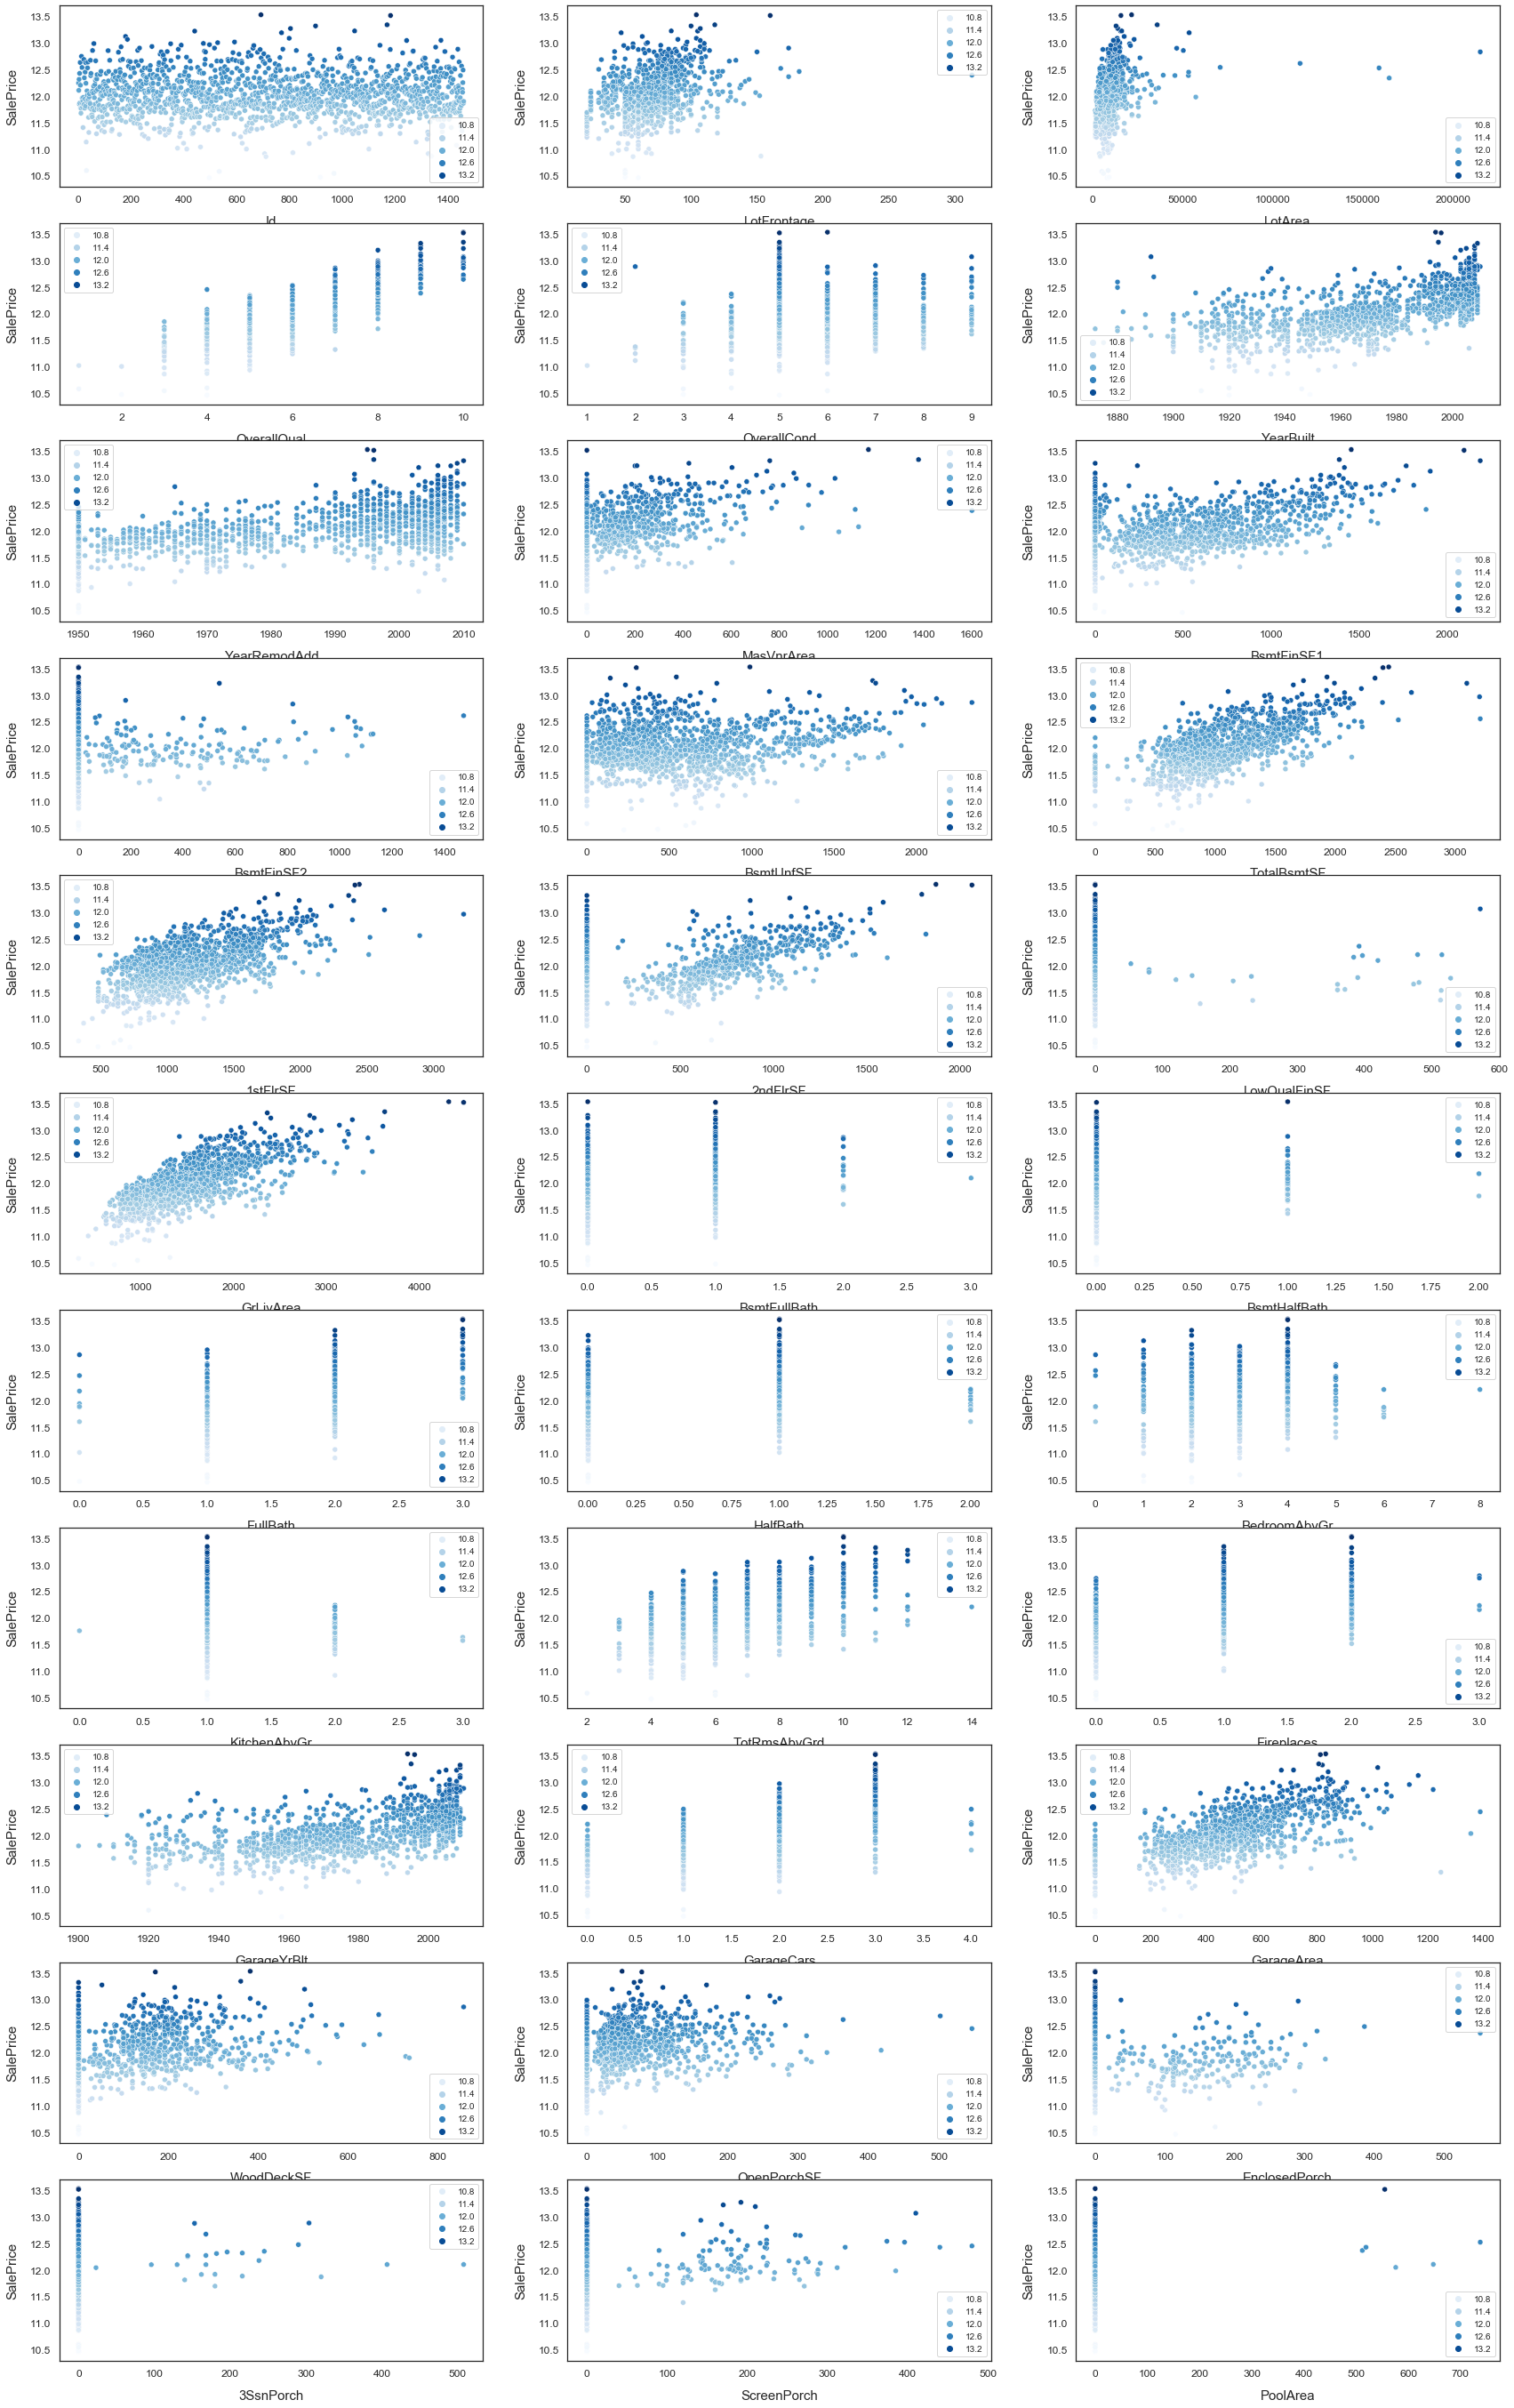

In [170]:
# check numeric columns
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualize all
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train_df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
plt.savefig('sdf.png')        
plt.show()

In [38]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [39]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [141]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.05,
                       n_estimators=4000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=29,
                       reg_alpha=0.0001,
                       reg_lambda = 0.05,
                       random_state=42)
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1400,
                          max_depth=15,
                          min_samples_split=2,
                          min_samples_leaf=2,
                          max_features=None,
                          oob_score=True,
                          random_state=45)



In [127]:
#finding the most suitable values
cv_params = {'n_estimators': [4000, 5000, 6000, 7000, 8000]}
other_params = {'learning_rate': 0.1, 'n_estimators': 6000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_GBM.best_params_))
print('Best Model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.0min finished


Best Parameter number：{'n_estimators': 4000}
Best Model score:0.9091983908540214


In [128]:

cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 4000, 'max_depth': 4, 'min_child_weight': 0, 'seed': 27,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.6, 'reg_alpha': 0.00006, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_GBM.best_params_))
print('Best Model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.1min finished


Best Parameter number：{'learning_rate': 0.05}
Best Model score:0.8841397441236002


In [129]:
cv_params = {'reg_alpha': [0.001, 0.0001, 0.00001, 0.0004, 0.00006], 'reg_lambda':[0.05, 0.1, 1,2,3]}
other_params = {'learning_rate': 0.05, 'n_estimators': 4000, 'max_depth': 4, 'min_child_weight': 0, 'seed': 27,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.6, 'reg_alpha': 0.00006, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_GBM.best_params_))
print('Best Model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 15.6min finished


Best Parameter number：{'reg_alpha': 0.001, 'reg_lambda': 0.05}
Best Model score:0.8906281323989931


In [130]:
cv_params = {'subsample': [0.5,0.6,0.7,0.8], 'colsample_bytree':[0.6,0.7,0.8,0.9]}
other_params = {'learning_rate': 0.05, 'n_estimators': 4000, 'max_depth': 4, 'min_child_weight': 0, 'seed': 27,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 0.05}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_GBM.best_params_))
print('Best Model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 10.1min finished


Best Parameter number：{'colsample_bytree': 0.7, 'subsample': 0.7}
Best Model score:0.8906281323989931


In [131]:
cv_params = {'gamma': [0, 0.2, 0.4, 0.6], 'seed':[25,27,29,31]}
other_params = {'learning_rate': 0.05, 'n_estimators': 4000, 'max_depth': 4, 'min_child_weight': 0, 'seed': 27,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 0.05}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_GBM.best_params_))
print('Best Model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  9.2min finished


Best Parameter number：{'gamma': 0, 'seed': 29}
Best Model score:0.917616821361528


In [135]:
# Random forests Parameter test
cv_params = {'n_estimators': [1000,1200,1400,1600]}
other_params = {'n_estimators': 1200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None,
                    'oob_score': True, 'random_state': 42}

model = RandomForestRegressor(**other_params)
optimized_RFR = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_RFR.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_RFR.best_params_))
print('Best Model score:{0}'.format(optimized_RFR.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.4min finished


Best Parameter number：{'n_estimators': 1400}
Best Model score:0.8801273677182813


In [136]:
# Random forests Parameter test
cv_params = {'max_depth': [10,15,20,25]}
other_params = {'n_estimators': 1400, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None,
                    'oob_score': True, 'random_state': 42}

model = RandomForestRegressor(**other_params)
optimized_RFR = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_RFR.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_RFR.best_params_))
print('Best Model score:{0}'.format(optimized_RFR.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.4min finished


Best Parameter number：{'max_depth': 15}
Best Model score:0.8801273677182813


In [138]:
# Random forests Parameter test
cv_params = {'min_samples_split': [2,5,10,15,20],'min_samples_leaf': [2,5,10,15,20],'random_state': [37,39,42,45,47]}
other_params = {'n_estimators': 1400, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None,
                    'oob_score': True, 'random_state': 42}

model = RandomForestRegressor(**other_params)
optimized_RFR = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_RFR.fit(X, train_labels)
print('Best Parameter number：{0}'.format(optimized_RFR.best_params_))
print('Best Model score:{0}'.format(optimized_RFR.best_score_))

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 25.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 53.1min
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed: 69.4min finished


Best Parameter number：{'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 45}
Best Model score:0.886615087695917


In [53]:
scores = {}
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1370 (0.0188)


In [142]:
#Fit model
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))
xgb_model_full_data = xgboost.fit(X, train_labels)
svr_model_full_data = svr.fit(X, train_labels)
ridge_model_full_data = ridge.fit(X, train_labels)
rf_model_full_data = rf.fit(X, train_labels)

[03:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from

[03:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[03:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [148]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from

ridge: 0.1101 (0.0161)


D:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [149]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[03:57:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:18

In [150]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1095 (0.0198)


In [153]:
scores = {'rf': (0.13695090982853994, 0.01882087050649953),
 'ridge': (0.1101348079201732, 0.01605443796964475),
 'xgb': (0.11466123471349705, 0.012846119036082739),
 'svr': (0.10954772758163156, 0.01984209997477569)}

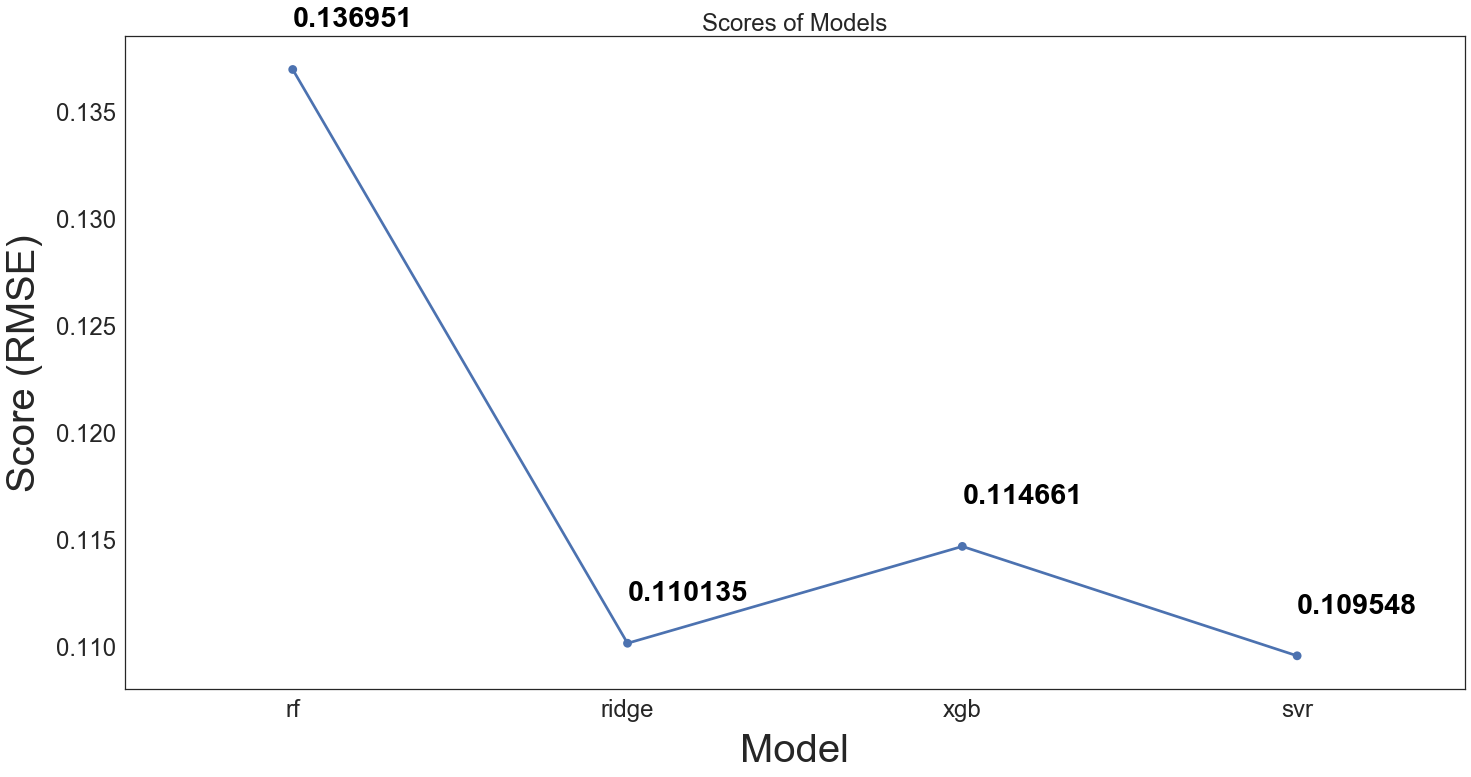

In [168]:
# Plot the predictions for each model
sns.set_style("white")

fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=40, labelpad=12.5)
plt.xlabel('Model', size=40, labelpad=12.5)
plt.tick_params(axis='x', labelsize=24 )
plt.tick_params(axis='y', labelsize=24)


plt.title('Scores of Models', size=24)
plt.savefig('save_as_a_png.png')
plt.show()
